In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
sns.set_style('darkgrid')

In [3]:
%matplotlib inline

In [6]:
# loading the .xlsx to a pandas dataframe
vessel_df = pd.read_excel('particulars_dataset_jda_assignment.xlsx')

## EDA

In [7]:
vessel_df.head(5)

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
0,9784269,5098185,15226,A,2019-01-01
1,9795622,5640800,21237,A,2019-01-01
2,9811000,5631605,20000,A,2019-01-01
3,9619983,157413,18270,A,2019-01-02
4,9695121,994728,19000,B,2019-01-02


In [8]:
vessel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   IMO        1202 non-null   int64         
 1   SHIP_ID    1202 non-null   int64         
 2   TEU        1202 non-null   int64         
 3   PORT_NAME  1202 non-null   object        
 4   TIMESTAMP  1202 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.1+ KB


Our dataset consists of 5 columns and 1202 rows. The row names are **IMO**, **SHIP_ID**, **TEU**, **PORT_NAME**, and **TIMESTAMP**.<br>

In more details:

1. **IMO**: refers to the IMO number of ships which is a unique identifier for ships
2. **SHIP_ID**: probably refers to a unique identifier set by marine traffic
3. **TEU**: stands for twenty-foot equivalent unit, and refers to the cargo capacity of a container vessel, meaning how many TEU a container vessel could carry.
4. **PORT_NAME**: refers to the 4 container ports
5. **TIMESTAMP**: refers to the date of arrival of the Ultra large container vessels

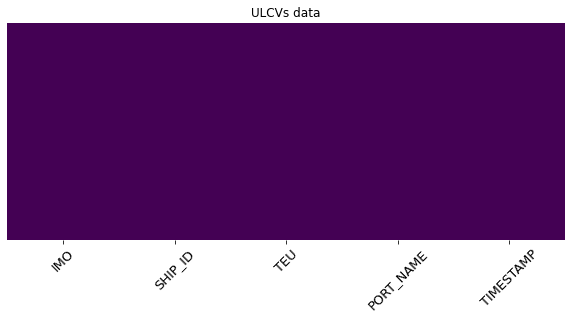

In [23]:
# checking for missing values
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,1,1)
sns.heatmap(vessel_df.isnull(),yticklabels=False,cbar=False,cmap='viridis', ax = ax1)
ax1.tick_params(axis='x', labelsize=13, rotation = 45)
ax1.set_title('ULCVs data');

In [22]:
vessel_df.isnull().sum()

IMO          0
SHIP_ID      0
TEU          0
PORT_NAME    0
TIMESTAMP    0
dtype: int64

**There are no missing values in our data set**

### IMO feature

In [54]:
vessel_df.duplicated(subset=['IMO'], keep=False).sum()

1198

In [57]:
(~vessel_df.duplicated(subset=['IMO'], keep=False)).sum()

4

In [58]:
vessel_df['IMO'].nunique()

173

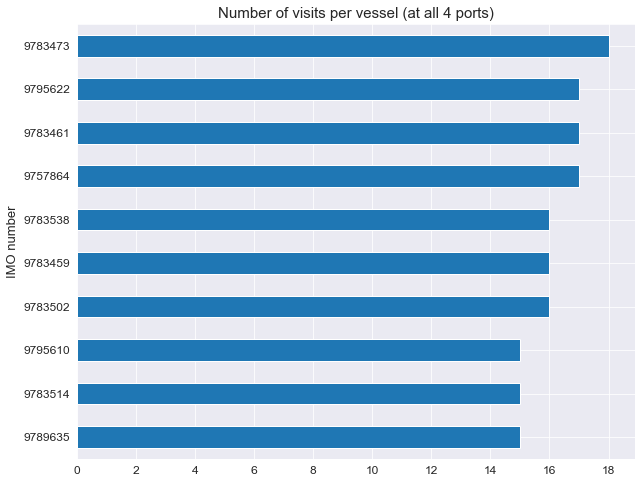

In [71]:
fig = plt.figure(figsize=(10,8))
vessel_df['IMO'].value_counts( ascending=True).iloc[-10:].plot(kind='barh')
plt.xticks(np.arange(0,20,2), fontsize=12)
plt.title('Number of visits per vessel (at all 4 ports)', fontsize=15)
plt.ylabel('IMO number', fontsize=13)
plt.yticks(fontsize=12);

From the above we notice the following:

1. There are 173 unique ULCVs.
2. Only 4 ULCVs have visited those ports only once.
3. There 4 ULCVs which have visited thise ports a least 17 times.

#### TEU feature